Code die checkt of wij wav-files correct wegschrijven naar tf-records.


[link to original code](https://github.com/tensorflow/models/tree/master/research/audioset)

In [1]:
## Import packages
import os
import csv
import random
import numpy as np
import pandas as pd
from scipy.io import wavfile

import tensorflow as tf
from tensorflow import gfile
from tensorflow import logging

import vggish_input
import vggish_postprocess
import vggish_params
import vggish_slim

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
flags = tf.app.flags
FLAGS = flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')

flags.DEFINE_string(
    'audio_embedding_feature_name', 'audio_embedding',
    'Path to the VGGish checkpoint file.')

## De volgende bestanden komen uit het eerdere mapje 'models'. Nu heb ik ze in yt8m gezet.
## Deze zijn nodig om de embedding layer te maken
flags.DEFINE_string(
    'pca_params', 'models/vggish_pca_params.npz',
    'Path to the VGGish PCA parameters file.')

flags.DEFINE_string(
    'checkpoint', 'models/vggish_model.ckpt',
    'Path to the VGGish checkpoint file.')

flags.DEFINE_string(
    'yt_checkpoint', 'models/youtube_model.ckpt',
    'Path to the VGGish checkpoint file.')

In [101]:
silence = False

In [102]:
tfrecord_name = "test_embedding/_D.tfrecord"
wav_name = "test_embedding/youtube_D.wav"

if(silence):
    tfrecord_name = "test_embedding/-2.tfrecord"
    wav_name = "test_embedding/youtube-2.wav"

In [103]:
target_video_id = [b'_DHMdtRRJzE']

if(silence):
    target_video_id = [b'-2NVPmjojzE']

In [114]:
## Haal hier de example uit de tf-record (zoekend op video-id en dan handmatig checken op correcte seconden)

record_iterator = tf.python_io.tf_record_iterator(tfrecord_name)

## Met break: check alleen het eerste geluidsfragment uit de tf-record
embedding = None
    
for string_record in record_iterator:

    ## Take one example
    example = tf.train.SequenceExample()
    example.ParseFromString(string_record)
    
    video_id = example.context.feature['video_id'].bytes_list.value
    
    #video_id = str(video_id)[3:-2]
    if(video_id == target_video_id):
        embedding = example.feature_lists.feature_list['audio_embedding']
        break;

In [24]:
# Eerste seconde
for byte in embedding.feature[0].bytes_list.value[0]:
    print(byte, end='')
    print(" ", end='')

175 8 146 96 214 76 77 129 148 174 151 51 120 147 101 35 109 238 196 193 0 208 99 177 69 152 150 185 123 68 193 131 106 82 139 130 139 120 184 136 115 174 31 144 123 163 132 92 123 110 126 93 129 77 86 150 125 106 113 206 130 121 121 97 174 168 81 124 144 135 146 112 127 188 138 154 132 137 93 168 100 193 152 130 91 102 138 202 146 88 63 145 95 112 110 171 88 50 122 210 207 121 120 114 106 182 84 114 170 130 178 136 67 136 72 55 147 184 48 216 101 116 100 83 170 147 69 255 

In [4]:
## Deze code is van inference.py gehaald.
## Op het einde wordt er een nieuwe sequence example gemaakt

## Function that takes examples from wav-file as input and returns a sequence example
def getSequenceExample(examples_batch, labels):
    
    # Prepare a postprocessor to munge the model embeddings.
    pproc = vggish_postprocess.Postprocessor(FLAGS.pca_params)

    with tf.Graph().as_default(), tf.Session() as sess:

        # Define the model: load the checkpoint and locate input and output tensors
        # Input: [batch_size, num_frames, num_bands] 
        # where [num_frames, num_bands] represents log-mel-scale spectrogram
        # Output: embeddings
        vggish_slim.define_vggish_slim(training=False)
        vggish_slim.load_vggish_slim_checkpoint(sess, FLAGS.checkpoint)

        features_tensor = sess.graph.get_tensor_by_name(
            vggish_params.VGGISH_INPUT_TENSOR_NAME)
        embedding_tensor = sess.graph.get_tensor_by_name(
            vggish_params.VGGISH_OUTPUT_TENSOR_NAME)

        # Run inference and postprocessing.
        [embedding_batch] = sess.run([embedding_tensor],
                                     feed_dict={features_tensor: examples_batch})
        print(embedding_batch)

        postprocessed_batch = pproc.postprocess(embedding_batch)
        print(postprocessed_batch)


        ## Maak sequence example
        seq_example = tf.train.SequenceExample(
            feature_lists = tf.train.FeatureLists(
                feature_list={
                    FLAGS.audio_embedding_feature_name:
                        tf.train.FeatureList(
                            feature=[
                                tf.train.Feature(
                                    bytes_list=tf.train.BytesList(
                                        value=[embedding.tobytes()]))
                                for embedding in postprocessed_batch
                            ]
                        )
                }
            )
        )
        
    return(embedding_batch, postprocessed_batch, seq_example)

In [5]:
## Maak eerst de examples
examples_batch = vggish_input.wavfile_to_examples(wav_name)
print("Examples shape: " + str(examples_batch.shape))

## Maak nu de embedding (met functie hierboven), pas PCA toe en maak er bytes van
embedding_batch, postprocessed_batch, seq_example = getSequenceExample(examples_batch, [161])

Examples shape: (10, 96, 64)
INFO:tensorflow:Restoring parameters from models/vggish_model.ckpt
[[0.         0.         0.         ... 0.         0.22485782 0.174345  ]
 [0.         0.         0.         ... 0.         0.22157401 0.1709801 ]
 [0.         0.         0.         ... 0.         0.22676541 0.17496386]
 ...
 [0.28435314 0.         0.23397322 ... 0.06538102 0.         0.        ]
 [0.05801097 0.         0.11374274 ... 0.         0.         0.        ]
 [0.         0.01519154 0.15988308 ... 0.1020571  0.         0.        ]]
[[175   8 146 ... 148  70 255]
 [174   8 146 ... 151  70 255]
 [175   8 146 ... 146  69 255]
 ...
 [152   0 162 ...   0 180 255]
 [154   3 154 ...   0 186 255]
 [154   0 149 ...   0 255 255]]


In [129]:
byte_string_2 = seq_example.feature_lists.feature_list['audio_embedding'].feature[1].bytes_list.value[0]
byte_string_2

b'\xbc\x0b\x82g\xd5DH\x82\x1b\xd6Dk\xaeK|J\x99t\xda\x8d%\xe7\xa1\xa4y\xb7\x96\xd7\xbe\xcdiP\xff\x8c\xb1\x90\x98\n?$\x84\xf7I%z\xb3\x82\xcds\xff\x88\x8b1\xc9\x87j\x97\xa8{\xae\xd7s+\xa9\xf1\xea[>\xd2\x7f\xc3\xae\xa0\xf0\x13\xccZ\xbdiaQ\xff\x93a\xbb\x82\xff\xe7m\x87\x80\xdda\xe8Y\x15\x0f\x00\xff\x00\xff\x00\xffo_\xbbx\xdck\xfa\x8e\xa5OY\xfa\x006\xa0\x00\xff\xf6\xff\x00\x00\xfd\x00M\xff'

In [130]:
bs = np.fromstring(byte_string_2, dtype=np.uint8)
print(bs)

[188  11 130 103 213  68  72 130  27 214  68 107 174  75 124  74 153 116
 218 141  37 231 161 164 121 183 150 215 190 205 105  80 255 140 177 144
 152  10  63  36 132 247  73  37 122 179 130 205 115 255 136 139  49 201
 135 106 151 168 123 174 215 115  43 169 241 234  91  62 210 127 195 174
 160 240  19 204  90 189 105  97  81 255 147  97 187 130 255 231 109 135
 128 221  97 232  89  21  15   0 255   0 255   0 255 111  95 187 120 220
 107 250 142 165  79  89 250   0  54 160   0 255 246 255   0   0 253   0
  77 255]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


In [25]:
# Terug naar tf-record om te vergelijken
bs_2 = np.fromstring(embedding.feature[1].bytes_list.value[0], dtype=np.uint8)
bs_2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


array([175,   8, 146,  96, 214,  76,  77, 129, 148, 174, 151,  51, 120,
       147, 101,  35, 109, 238, 196, 193,   0, 208,  99, 177,  69, 152,
       150, 185, 123,  68, 193, 131, 106,  82, 139, 130, 139, 120, 184,
       136, 115, 174,  31, 144, 123, 163, 132,  92, 123, 110, 126,  93,
       129,  77,  86, 150, 125, 106, 113, 206, 130, 121, 121,  97, 174,
       168,  81, 124, 144, 135, 146, 112, 127, 188, 138, 154, 132, 137,
        93, 168, 100, 193, 152, 130,  91, 102, 138, 202, 146,  88,  63,
       145,  95, 112, 110, 171,  88,  50, 122, 210, 207, 121, 120, 114,
       106, 182,  84, 114, 170, 130, 178, 136,  67, 136,  72,  55, 147,
       184,  48, 216, 101, 116, 100,  83, 170, 147,  69, 255], dtype=uint8)

In [133]:
import matplotlib.pyplot as plt

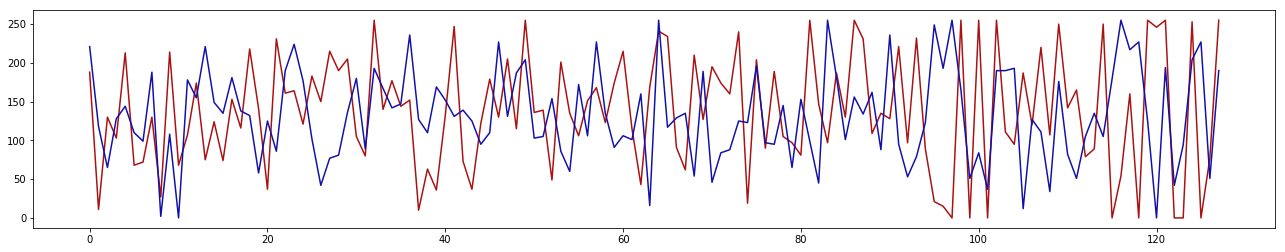

In [134]:
plt.plot(bs, color='#AA1111')
plt.plot(bs_2, color='#1111AA')
plt.subplots_adjust(right=3, wspace=0)
plt.show()

In [4]:
tfrecord_name = "tfrecords/added_data/elephant_test.tfrecord"

In [10]:
## Haal hier de example uit de tf-record (zoekend op video-id en dan handmatig checken op correcte seconden)

record_iterator = tf.python_io.tf_record_iterator(tfrecord_name)

## Met break: check alleen het eerste geluidsfragment uit de tf-record
nr_examples = 0
    
for string_record in record_iterator:

    example = tf.train.SequenceExample()
    example.ParseFromString(string_record)
    print(example)
    nr_examples += 1
    if(nr_examples>3):
        break;

context {
  feature {
    key: "labels"
    value {
      int64_list {
        value: 13
      }
    }
  }
  feature {
    key: "video_id"
    value {
      bytes_list {
        value: "-1LrH01Ei1w"
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "audio_embedding"
    value {
      feature {
        bytes_list {
          value: "\231\017\260e\354+\243_\271\264]a\302\244\027\000\207\202\305\263U\271\325m\023\215WV,\262\216qu{$\307[\231\266d\215\345\007A\245\214\000\322&\305aN\244\177\216\016\006@f\377w\000\000\312\324\247\377\377\344\000zEa\347\234\000\273cX\360uW\377\326\003\007\000\310\360\000\326\350t\202>2\256\000\023\321)\000\365\314\000\377\377\215\3779\377\377\241>\302W\217\\\000\377\200\300\000\212\377\2444\377"
        }
      }
      feature {
        bytes_list {
          value: "\234\020\252Z\335;\251^\277\273<\226\314\245\000\000nj\272\236+\315\313I4`\177wXe_c\250a8\317A\227\305_\312\336\000\204s\237\000\256&\266\336Vc5v\000g\005I\377f \037\314\230d\377\265\

In [6]:
nr_examples

153